# PyTorch Lab 2

Written by Prachya Boonkwan (Arm)

In [2]:
# !pip install -q http://download.pytorch.org/whl/cpu/torch-0.4.1-cp36-cp36m-linux_x86_64.whl torchvision tqdm
!pip install -q torch torchvision tqdm

# `https://tinyurl.com/yahnrgfl` 

## Learning the XOR Gate

In this workshop, we are going to imitate the XOR (eXclusive OR) gate with a multilayer perceptron.

## Header

This part is the header of the code. My favorite import aliases for PyTorch are as follows. This will be very useful for speed coding.

In [4]:
#!/usr/bin/env python3
#-*- coding: utf-8 -*-

import torch as T
import torch.nn as N
import torch.optim as O

from tqdm.autonotebook import tqdm    # Nice progressbar
import matplotlib.pyplot as plt
%matplotlib inline

import random

-----

## Neural Networks as Linear Transformation

### Linear Layer

In a nutshell, the simplest form of neural networks is a series of linear transformation layers. We can create a linear transformation layer, or *linear layer*, by the command `N.Linear`. For example, this is how we create a linear layer that takes 5 input units and produces 3 output units.

In [5]:
linear_layer = N.Linear(5, 3)
print(linear_layer)

Linear(in_features=5, out_features=3, bias=True)


This linear layer takes an input vector of size 5 and produces an output vector of size 3. In fact, a linear layer is equivalent to a matrix of the corresponding size. For example, `N.Linear(5, 3)` is equivalent to a matrix $\mathbf{A}$ of dimension 5 × 3.

$$
\begin{eqnarray}
    \left[ \mathbf{v}_\textrm{out} \right]_{3} & = & \left( \mathbf{A}_{5 \times 3} \right)^\top \times \left[ \mathbf{v}_\textrm{in} \right]_{5}
\end{eqnarray}
$$

In [6]:
input_vec = T.FloatTensor([1.0, 2.0, 3.0, 4.0, 5.0])
print('input_vec  = {}'.format(input_vec))

output_vec = linear_layer(input_vec)
print('output_vec = {}'.format(output_vec))

input_vec  = tensor([1., 2., 3., 4., 5.])
output_vec = tensor([ 1.6737, -2.4226,  0.0692], grad_fn=<AddBackward0>)


### A Series of Linear Transformation

Let's create some more linear layers.

In [7]:
layer1 = N.Linear(5, 3)
layer2 = N.Linear(3, 4)

We can sequentially feed, or *feed-forward*, an input vector to these layers. Let's see how each step goes.

In [8]:
input_vec = T.FloatTensor([1.0, 2.0, 3.0, 4.0, 5.0])
print('input_vec    = {}'.format(input_vec))

output_vec_1 = layer1(input_vec)
print('output_vec_1 = {}'.format(output_vec_1))

output_vec_2 = layer2(output_vec_1)
print('output_vec_2 = {}'.format(output_vec_2))

input_vec    = tensor([1., 2., 3., 4., 5.])
output_vec_1 = tensor([ 2.1050, -2.5869, -1.6070], grad_fn=<AddBackward0>)
output_vec_2 = tensor([ 1.9596, -0.2765, -0.5675,  0.5031], grad_fn=<AddBackward0>)


Note that we can always print out the output of each step, making it much easier to debug your code in PyTorch than in native Tensorflow.

### Multilayer Perceptron

A multilayer perceptron (MLP) comprises a series of linear layers. We can create a MLP with the command `N.Sequential`.

In [9]:
mlp_model = N.Sequential(
    N.Linear(5, 3),
    N.Linear(3, 4)
)
print(mlp_model)

Sequential(
  (0): Linear(in_features=5, out_features=3, bias=True)
  (1): Linear(in_features=3, out_features=4, bias=True)
)


We can feed-forward an input vector to the created MLP and obtain an output vector as well. The produced output vector is a prediction made by the MLP. This is still equivalent to applying a series of linear transformation:

$$
\begin{eqnarray}
    \left[ \mathbf{v}_\textrm{out} \right]_4 & = & \left( \mathbf{A}_{5 \times 3} \times \mathbf{B}_{3 \times 4} \right)^\top \times \left[ \mathbf{v}_\textrm{in} \right]_5
\end{eqnarray}
$$

where $\mathbf{A}$ and $\mathbf{B}$ are linear layers.

In [10]:
prediction = mlp_model(input_vec)
print('prediction = {}'.format(prediction))

prediction = tensor([ 1.1368, -0.4607,  1.7521, -2.3646], grad_fn=<AddBackward0>)


### Loss Function: Mean Squared Error

Next, we want to compute the difference, i.e. the *loss*, between a prediction vector $\mathbf{y}$ and a desired output vector $\mathbf{y}'$. In this workshop, we will use the mean squared error (MSE), where we compute the average of squared difference between each element pair $y_i$ and $y'_i$.

$$
\begin{eqnarray}
    \mathrm{MSE} & = & \frac{1}{N} \sum_{i = 1}^N \left( y_i - y'_i \right)^2
\end{eqnarray}
$$

In [11]:
desired_output_vec = T.FloatTensor([4.0, 3.0, 2.0, 1.0])
print('prediction = {}'.format(prediction))
print('desired_output_vec = {}'.format(desired_output_vec))

loss_func = N.MSELoss()

loss = loss_func(prediction, desired_output_vec)
print('loss = {}'.format(loss))

prediction = tensor([ 1.1368, -0.4607,  1.7521, -2.3646], grad_fn=<AddBackward0>)
desired_output_vec = tensor([4., 3., 2., 1.])
loss = 7.889118194580078


### Parameter Optimization

There are several parameter optimizers in PyTorch. Stochastic Gradient Descent (SGD) is the simplest and easiest to understand. This is how we create an SGD optimizer with the command `O.SGD`. Note that it takes the parameters of our model of interest and a learning rate.

In [12]:
optimizer = O.SGD(mlp_model.parameters(), lr=0.01)
print(optimizer)

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.01
    momentum: 0
    nesterov: False
    weight_decay: 0
)


This is one step of parameter optimization. First, we clear the gradient cache of the optimizer. The loss previously calculated is then used to perform backpropagation through the model. Finally, we update the parameters with the command `step()`.

In [13]:
optimizer.zero_grad()        # Clear the gradient cache
loss.backward()              # Perform backpropagation
optimizer.step()             # Update the parameters

Let's observe the change in parameters after just one step of optimization. Note that the new prediction is approaching the desired output vector.

In [14]:
print('Before: prediction = {}'.format(prediction))

new_prediction = mlp_model(input_vec)
print('After : prediction = {}'.format(new_prediction))

Before: prediction = tensor([ 1.1368, -0.4607,  1.7521, -2.3646], grad_fn=<AddBackward0>)
After : prediction = tensor([ 1.2922, -0.1237,  1.5357, -1.8335], grad_fn=<AddBackward0>)


Let's iterate through parameter optimization for 10 times. Note that the loss is getting smaller, because the new prediction of each step is getting closer and closer to the desired output vector.

In [19]:
for i in range(10):
    step_prediction = mlp_model(input_vec)
    loss = loss_func(step_prediction, desired_output_vec)
    print('Iteration {}: loss = {}'.format(i, loss))
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Iteration 0: loss = 0.0006886095507070422
Iteration 1: loss = 0.00039063242729753256
Iteration 2: loss = 0.000224679519305937
Iteration 3: loss = 0.00013102880620863289
Iteration 4: loss = 7.744423783151433e-05
Iteration 5: loss = 4.635062214219943e-05
Iteration 6: loss = 2.805778058245778e-05
Iteration 7: loss = 1.7157004549517296e-05
Iteration 8: loss = 1.058393536368385e-05
Iteration 9: loss = 6.577178737643408e-06


Let's see how close to the desired output vector the latest prediction is, compared with the first prediction.

In [20]:
print('Before: prediction = {}'.format(prediction))
new_prediction = mlp_model(input_vec)
print('After : prediction = {}'.format(new_prediction))
print('Desired output vec : {}'.format(desired_output_vec))

Before: prediction = tensor([ 1.1368, -0.4607,  1.7521, -2.3646], grad_fn=<AddBackward0>)
After : prediction = tensor([3.9999, 3.0012, 1.9988, 0.9963], grad_fn=<AddBackward0>)
Desired output vec : tensor([4., 3., 2., 1.])


The more iterations, the closer the prediction is to the desired output vector.

-----

## Learning the XOR Gate with Multilayer Perceptrons

In this section, we will design a multilayer perceptron and train it to imitate an XOR gate.

### Configuration

In [21]:
dim_input = 2                         # DO NOT CHANGE ME: input dimension
dim_hidden = 8                        # Dimension for the hidden layer
dim_output = 1                        # DO NOT CHANGE ME: output dimension

no_training = 1000                    # Number of training data
no_testing = 100                      # Number of testing data

epochs = 40                           # Number of training iterations
loss_fn = N.MSELoss()                 # Loss function
learning_rate = 0.01                  # Learning rate

### Generating XOR Datasets

We generate a dataset for training/testing our MLP as follows. 

1. Create a list for storing the dataset. Let's name it $D$.
2. Repeat for the specified times
   1. We random two numbers ranging from 0 to 1 by `random.randint(0, 1)`, say $a$ and $b$. They will be the inputs of an XOR gate.
   2. We compute the result of $a \textrm{ XOR } b$. Let's name it $q$.
   3. Append $((a, b), q)$ to $D$.
3. Return $D$ as a result.

In [22]:
def gen_xor_dataset(size):
    dataset = []
    
    for i in range(size):
        
        # Random two values: a and b
        a = (random.randint(0, 1) == 1)
        b = (random.randint(0, 1) == 1)
        
        # q = a XOR b
        q = (a != b)
            
        input_features = (a, b)
        output_class = q
        dataset.append( (input_features, output_class) )
        
    return dataset

Let's generate the training and testing sets.

In [23]:
training_set = gen_xor_dataset(no_training)
testing_set = gen_xor_dataset(no_testing)

### Training Procedure

The training procedure follows the standard iteration of parameter optimization.

1. Repeat for the specified number of iterations (a.k.a. *epochs*)
   1. Shuffle the dataset D
   2. For each tuple ((a, b), q) in the dataset D
      1. Create an input vector $\mathbf{x}$, where $x_1 = a$ and $x_2 = b$.
      2. Create a desired output vector $\mathbf{y}'$, where $y_1 = q$.
      3. Compute a prediction vector $\mathbf{y}$ out of the model by feed-forwarding the input vector $\mathbf{x}$.
      4. Compute the loss between $\mathbf{y}$ and $\mathbf{y}'$.
      5. Perform backpropagation with respect to the loss.
   3. Store the loss history.
2. Plot a line chart of the loss history with Matplotlib.

In [24]:
def train_model(xor_model, training_data):
    optimizer = O.SGD(xor_model.parameters(), lr=learning_rate)
    no_samples = len(training_data)
    loss_history = []
    
    for i in tqdm(range(epochs)):
        total_loss = 0.0
        random.shuffle(training_data)
        
        for (input_features, output_class) in training_data:
            ((a, b), q) = (input_features, output_class)
            
            x = T.zeros(dim_input)     # Input vector
            y = T.zeros(dim_output)    # Output vector
            if a: x[0] = 1.0
            if b: x[1] = 1.0
            if q: y[0] = 1.0
                
            prediction = xor_model(x)  # Perform prediction
            
            loss = loss_fn(prediction, y)
            total_loss += loss.item()
            
            optimizer.zero_grad()      # Clear gradient cache
            loss.backward()            # Perform backpropagation
            optimizer.step()           # Update the model parameters
        
        loss_history.append(total_loss / no_samples)
        
    # Plot the loss history with Matplotlib
    epoch_count = range(1, epochs + 1)
    plt.plot(epoch_count, loss_history, 'b--')
    plt.legend(['Training Loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

### Testing Procedure

Let's measure the accuracy of a model.

1. Let $c$ be a counter of correct predictions, and $N$ be the number of testing samples.
2. For each ((a, b), q) in the testing set
   1. Create an input vector $\mathbf{x}$, where $x_1 = a$ and $x_2 = b$.
   2. Compute a prediction vector $\mathbf{y}$ out of the model by feed-forwarding the input vector $\mathbf{x}$.
   3. Infer a predicted class $q'$ from $\mathbf{y}$. If $y_1 \geq 0.5$, we let $q' = \mathbb{T}$. Otherwise, $q' = \mathbb{F}$.
   4. If $q = q'$, then we increase the counter $c$.
3. Calculate the accuracy by the formula $ \mathrm{ACC} = c / N $.

In [25]:
def test_model(xor_model, testing_data):
    no_correct = 0.0

    for (input_features, output_class) in testing_data:
        ((a, b), q) = (input_features, output_class)

        x = T.zeros(dim_input)     # dim_input = 2
        if a: x[0] = 1.0
        if b: x[1] = 1.0

        pred = xor_model(x)
        pred_class = True if pred[0] >= 0.5 else False
        result = 'Correct' if pred_class == q else 'Incorrect'
        if pred_class == q: no_correct += 1
        print('{:>5} XOR {:>5} = {:>5}  |  prediction = {:>5}  |  {}'.format(
           str(a), str(b), str(q), str(pred_class), str(result)
        ))

    accuracy = 100 * no_correct / no_testing
    print('\nAccuracy = {}'.format(accuracy))

-------

## Model 1: A Very Simple Model

### Model Design

Our endeavor to the XOR gate begins with a simple MLP. This MLP contains just two linear layers.

In [26]:
xor_model_1 = N.Sequential(
    N.Linear(dim_input, dim_hidden),
    N.Linear(dim_hidden, dim_output)
)

print('Model 1:\n{}'.format(xor_model_1))

Model 1:
Sequential(
  (0): Linear(in_features=2, out_features=8, bias=True)
  (1): Linear(in_features=8, out_features=1, bias=True)
)


### Training

Let's train Model 1 with the training set!

  0%|          | 0/40 [00:00<?, ?it/s]

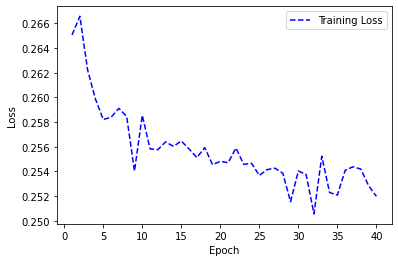

In [27]:
train_model(xor_model_1, training_set)

**N.B.** Observe the training loss. How much loss can Model 1 reduce?

### Testing

Let's test Model 1 with the testing set!

In [28]:
test_model(xor_model_1, testing_set)

 True XOR False =  True  |  prediction = False  |  Incorrect
False XOR False = False  |  prediction = False  |  Correct
 True XOR False =  True  |  prediction = False  |  Incorrect
False XOR False = False  |  prediction = False  |  Correct
False XOR  True =  True  |  prediction = False  |  Incorrect
False XOR  True =  True  |  prediction = False  |  Incorrect
False XOR False = False  |  prediction = False  |  Correct
False XOR False = False  |  prediction = False  |  Correct
 True XOR False =  True  |  prediction = False  |  Incorrect
False XOR False = False  |  prediction = False  |  Correct
 True XOR False =  True  |  prediction = False  |  Incorrect
 True XOR False =  True  |  prediction = False  |  Incorrect
 True XOR  True = False  |  prediction = False  |  Correct
False XOR False = False  |  prediction = False  |  Correct
False XOR False = False  |  prediction = False  |  Correct
 True XOR  True = False  |  prediction = False  |  Correct
 True XOR  True = False  |  prediction = F

### Exercise

Explain why we do not get 100% accuracy despite our high hope in neural networks. In particular, observe the predictions; they can be very strange! (*Hint:* There is something to do with the range of the input values of each linear layer.)

-------

## Model 2: Adding Activation Function

### Model Design

Let's introduce an activation function, e.g. sigmoid, into the model. The sigmoid function `N.Sigmoid` will shrink the range of the second linear layer to $[0, 1]$.

In [29]:
xor_model_2 = N.Sequential(
    N.Linear(dim_input, dim_hidden),
    N.Sigmoid(),
    N.Linear(dim_hidden, dim_output)
)

print('Model 2:\n{}'.format(xor_model_2))

Model 2:
Sequential(
  (0): Linear(in_features=2, out_features=8, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=8, out_features=1, bias=True)
)


### Training

Let's train Model 2 with the training set.

  0%|          | 0/40 [00:00<?, ?it/s]

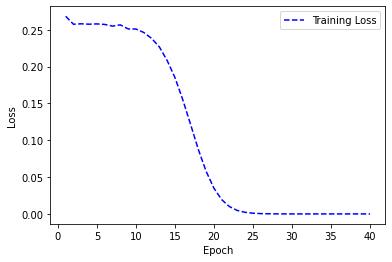

In [30]:
train_model(xor_model_2, training_set)

**N.B.** Observe the training loss. Compare it to the training loss of Model 1. Which one is better?

### Testing

Let's test Model 2 with the testing set.

In [31]:
test_model(xor_model_2, testing_set)

 True XOR False =  True  |  prediction =  True  |  Correct
False XOR False = False  |  prediction = False  |  Correct
 True XOR False =  True  |  prediction =  True  |  Correct
False XOR False = False  |  prediction = False  |  Correct
False XOR  True =  True  |  prediction =  True  |  Correct
False XOR  True =  True  |  prediction =  True  |  Correct
False XOR False = False  |  prediction = False  |  Correct
False XOR False = False  |  prediction = False  |  Correct
 True XOR False =  True  |  prediction =  True  |  Correct
False XOR False = False  |  prediction = False  |  Correct
 True XOR False =  True  |  prediction =  True  |  Correct
 True XOR False =  True  |  prediction =  True  |  Correct
 True XOR  True = False  |  prediction = False  |  Correct
False XOR False = False  |  prediction = False  |  Correct
False XOR False = False  |  prediction = False  |  Correct
 True XOR  True = False  |  prediction = False  |  Correct
 True XOR  True = False  |  prediction = False  |  Corre

### Exercises

1. Explain why we can now achieve 100% accuracy. (*Hint:* Is there something to do with the range of the input values of linear layers?)
2. Replace the sigmoid function `N.Sigmoid` in Model 2 with another one, such as the hyperbolic tangent `N.Tanh` (whose range is $[-1, 1]$) and the rectified unit function `N.ReLU` (whose range is $[0, \infty]$). Observe the difference of achieved accuracies.

--------

## Model 3: Modularizing a Model

In the previous models, we created a MLP by assembling linear layers and activation functions, and we had to do this every time when creating a new one. If we plan to create many models with the same neural architecture, we can instead modularize it as a class and instantiate a lot of them from that class.

### Model Design

We modularize a neural architecture by simply inheriting the class `N.Module`. There are two parts we have to work on.

The first part is the constructor method `__init__`. Here we take arguments and define necessary components according to them. In this example, it takes three arguments: `dim_input`, `dim_hidden`, and `dim_output`, respectively. Then we create two linear layers (`_input_to_hidden` and `_hidden_to_output`) and one sigmoid function (`_sigmoid`).

The second part is the method `forward`. In this example, it takes an input vector `x` and computes a prediction out of it. As we can see, we compute the prediction step-by-step as `out1`, `out2`, and `out3`. In the case of debugging, we can simply print out each step to investigate the errors. This capability makes your life as a developer a lot easier.

In [36]:
class XorModel(N.Module):

    def __init__(self, dim_input, dim_hidden, dim_output):
        super(XorModel, self).__init__()
        self._dim_input = dim_input
        self._dim_hidden = dim_hidden
        self._dim_output = dim_output

        self._input_to_hidden = N.Linear(self._dim_input, self._dim_hidden)
        self._sigmoid = N.Sigmoid()
        self._hidden_to_output = N.Linear(self._dim_hidden, self._dim_output)

    def forward(self, x):
        out1 = self._input_to_hidden(x)
        # print('out1 = {}'.format(out1))         # For debugging
        out2 = self._sigmoid(out1)
        # print('out2 = {}'.format(out2))         # For debugging
        out3 = self._hidden_to_output(out2)
        # print('out3 = {}'.format(out3))         # For debugging
        return out3

Once we define a model class, we can instantiate a model out of it. For example:

In [ ]:
xor_model_3 = XorModel(dim_input, dim_hidden, dim_output)
print('Model 3:\n{}'.format(xor_model_3))

Model 3:
XorModel(
  (_input_to_hidden): Linear(in_features=2, out_features=8, bias=True)
  (_sigmoid): Sigmoid()
  (_hidden_to_output): Linear(in_features=8, out_features=1, bias=True)
)


### Training

Training is pretty much the same.

  0%|          | 0/40 [00:00<?, ?it/s]

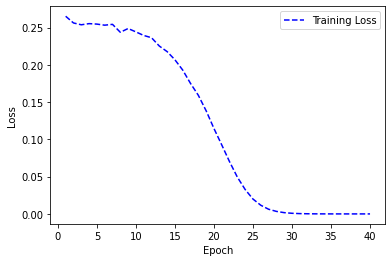

In [ ]:
train_model(xor_model_3, training_set)

### Testing

Testing is also the same.

In [ ]:
test_model(xor_model_3, testing_set)

False XOR False = False  |  prediction = False  |  Correct
 True XOR False =  True  |  prediction =  True  |  Correct
 True XOR  True = False  |  prediction = False  |  Correct
 True XOR  True = False  |  prediction = False  |  Correct
 True XOR  True = False  |  prediction = False  |  Correct
 True XOR False =  True  |  prediction =  True  |  Correct
 True XOR False =  True  |  prediction =  True  |  Correct
False XOR  True =  True  |  prediction =  True  |  Correct
False XOR False = False  |  prediction = False  |  Correct
False XOR False = False  |  prediction = False  |  Correct
 True XOR False =  True  |  prediction =  True  |  Correct
 True XOR False =  True  |  prediction =  True  |  Correct
 True XOR  True = False  |  prediction = False  |  Correct
False XOR False = False  |  prediction = False  |  Correct
 True XOR  True = False  |  prediction = False  |  Correct
 True XOR False =  True  |  prediction =  True  |  Correct
False XOR False = False  |  prediction = False  |  Corre

-------

## Exercises

### Exercise 1: Redesigning the Neural Architecture

Let's tweak Model 1 to boost its accuracy and convergence speed. Add linear layers and/or activation functions as much as you like and observe the training loss and accuracy achieved.

In [32]:
# Add some more layers and/or activation functions to improve the speed of convergence
xor_model_ex1 = N.Sequential(
    N.Linear(dim_input, dim_hidden),
    N.Linear(dim_hidden, dim_output)
)

print('Model Ex1:\n{}'.format(xor_model_ex1))

Model Ex1:
Sequential(
  (0): Linear(in_features=2, out_features=8, bias=True)
  (1): Linear(in_features=8, out_features=1, bias=True)
)


Now observe the training loss. Is the convergence getting faster?

  0%|          | 0/40 [00:00<?, ?it/s]

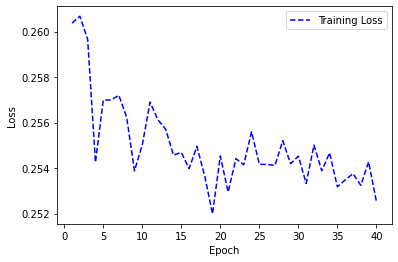

In [33]:
train_model(xor_model_ex1, training_set)

### Parameterized Training Procedure for Hacking

I slightly modified the training procedure to allow experiments on different loss functions and parameter optimizers.

In [34]:
def train_model_for_hacking(xor_model, training_data, loss_fn, optimizer):
    no_samples = len(training_data)
    loss_history = []
    
    for i in tqdm(range(epochs), leave=False):
        total_loss = 0.0
        random.shuffle(training_data)
        
        for (input_features, output_class) in training_data:
            ((a, b), q) = (input_features, output_class)
            
            x = T.zeros(dim_input)     # Input vector
            y = T.zeros(dim_output)    # Output vector
            if a: x[0] = 1.0
            if b: x[1] = 1.0
            if q: y[0] = 1.0
                
            prediction = xor_model(x)  # Perform prediction
            
            loss = loss_fn(prediction, y)
            total_loss += loss.item()
            
            optimizer.zero_grad()      # Clear gradient cache
            loss.backward()            # Perform backpropagation
            optimizer.step()           # Update the model parameters
        
        loss_history.append(total_loss / no_samples)
        
    # Plot the loss history with Matplotlib
    epoch_count = range(1, epochs + 1)
    plt.plot(epoch_count, loss_history, 'b--')
    plt.legend(['Training Loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

### Exercise 2: Varying the Optimizers

Now let's vary the parameter optimizers. Observe the training loss obtained from each optimizer. Which one converges faster?

Stochastic Gradient Descent


  0%|          | 0/40 [00:00<?, ?it/s]

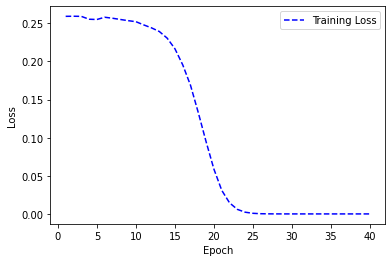

Adamax


  0%|          | 0/40 [00:00<?, ?it/s]

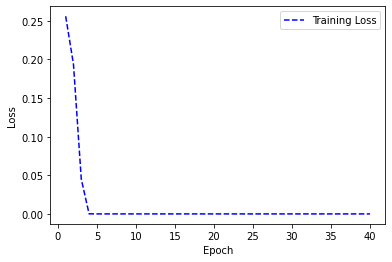

ADAM


  0%|          | 0/40 [00:00<?, ?it/s]

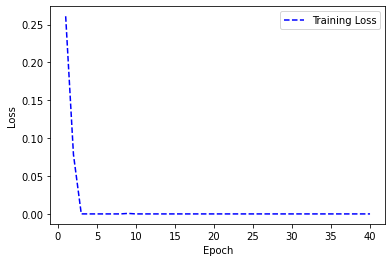

In [37]:
learning_rate_ex2 = 0.01

print('Stochastic Gradient Descent')
xor_model_sgd = XorModel(dim_input, dim_hidden, dim_output)
sgd = O.SGD(xor_model_sgd.parameters(), lr=learning_rate_ex2)
train_model_for_hacking(xor_model_sgd, training_set, N.MSELoss(), sgd)

print('Adamax')
xor_model_adamax = XorModel(dim_input, dim_hidden, dim_output)
adamax = O.Adamax(xor_model_adamax.parameters(), lr=learning_rate_ex2)
train_model_for_hacking(xor_model_adamax, training_set, N.MSELoss(), adamax)

print('ADAM')
xor_model_adam = XorModel(dim_input, dim_hidden, dim_output)
adam = O.Adam(xor_model_adam.parameters(), lr=learning_rate_ex2)
train_model_for_hacking(xor_model_adam, training_set, N.MSELoss(), adam)

### Exercise 3: Varying the Learning Rates

Now let's vary the learning rates. Observe the training loss obtained from each learning rate.

1. For some learning rates, the training loss fluctuates substantially. Explain why.
2. For some learning rates, the training loss converges too slowly. Explain why.
3. Which learning rate is the best in terms of the training loss?

Learning rate = 1.0


  0%|          | 0/40 [00:00<?, ?it/s]

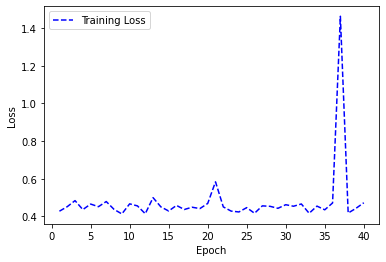

Learning rate = 0.1


  0%|          | 0/40 [00:00<?, ?it/s]

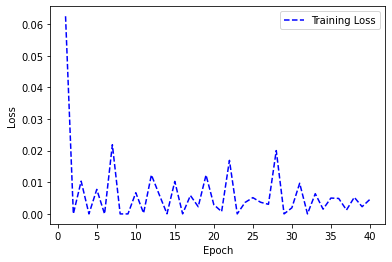

Learning rate = 0.01


  0%|          | 0/40 [00:00<?, ?it/s]

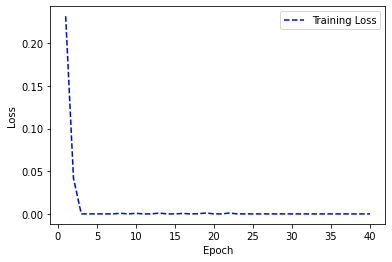

Learning rate = 0.001


  0%|          | 0/40 [00:00<?, ?it/s]

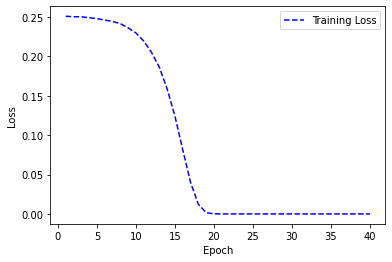

Learning rate = 0.0001


  0%|          | 0/40 [00:00<?, ?it/s]

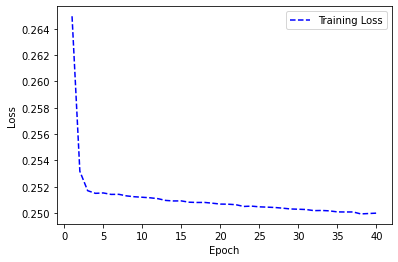

In [38]:
for learning_rate_ex3 in [1.0, 0.1, 0.01, 0.001, 0.0001]:
    print('Learning rate = {}'.format(learning_rate_ex3))
    xor_model = XorModel(dim_input, dim_hidden, dim_output)
    optimizer = O.Adam(xor_model.parameters(), lr=learning_rate_ex3)
    train_model_for_hacking(xor_model, training_set, N.MSELoss(), optimizer)